# Code Exploration

In [1]:
# let's make sure requirements are up to date
!pip install -r requirements.txt


In [7]:
# just an empty shell for now. my plan is to declare a utility class that can load stages and modules via a data constructor
# - and use ontology and reasoning to query the Knowledge Graph. Little by little...
from omni import Benchmark

In [3]:
i = Benchmark(name="Iris")
print(i.name)

Iris


# Benchmark Definition
Let's use the infamous Iris Benchmark for reference. This is just a particular topology for a Benchmark. We define it in `iris-benchmark.yaml`. Do note that the orchestrator `.gitlab-ci.yaml` can be dynamically generated from only the info contained here.

According to the plan, I'd like to have a declarative way (and a truly generic and flexible way) of declaring stages in a benchmark. This will give us, in time, the ability to control a `CompositePlan` with dynamic membership.

## Benchmark Definition File

This is a first proposal of how the benchmark definition file might look like:

```yaml
# name is the short orchestrator name
name: iris

# description is a longer description that we can display in the dashboard
description: simple benchmark demo with the iris dataset

# platform is the base url where to lookup relative project URIs
# in principle, this should be platform agnostic (by using a FQDN in the repo keyword)
platform: https://gitlab.renkulab.io/

# orchestrator is the orchestrator module. This benchmark definition should live there
# note that there can be only one orchestrator per benchmark.
orchestrator:
  name: iris-orchestrator
  url: https://gitlab.renkulab.io/omnibenchmark/iris_example/iris-orchestrator

steps:
  data:
    initial: true
    members:
      # what does it mean to provide more than one dataset? 
      # can a method choose to use any one of them? does it have to use all?
      - name: ref
        repo: omnibenchmark/iris_example/iris-dataset

      - name: noisy
        repo: omnibenchmark/iris_example/iris-noisy

  process:
    after:
      - data

    members:
      - name: filter
        repo: omnibenchmark/iris_example/iris-filter
      # which method brings this? this is something methods can decide to depend on?
      # can methods announce/register processing steps?

  parameters:
    after:
      - data

    members:
      - name: params
        repo: omnibenchmark/iris_example/iris-parameters

  methods:
    after:
      - process
      - parameters

    members:
      - name: random forest
        repo: benchmark/iris_example/iris-random-forest

      - name: lda
        repo: omnibenchmark/iris_example/iris-lda

  metrics:
    after:
      - methods

    members:
      - name: accuracy
        repo: omnibenchmark/iris_example/iris-accuracy

      - name: accuracy_pval
        repo: omnibenchmark/iris_example/iris-accuracy-pval


  summary:
    terminal: true

    after:
      - metrics

    members:
      - name: metrics
        repo: omnibenchmark/iris_example/irirs-summary-metrics
```

**Do note**: this file is equivalent to the current [gitlab-ci.yaml](https://gitlab.renkulab.io/omnibenchmark/iris_example/iris-orchestrator/-/blob/master/.gitlab-ci.yml#L21) in the orchestrator module (we can generate that from this one).

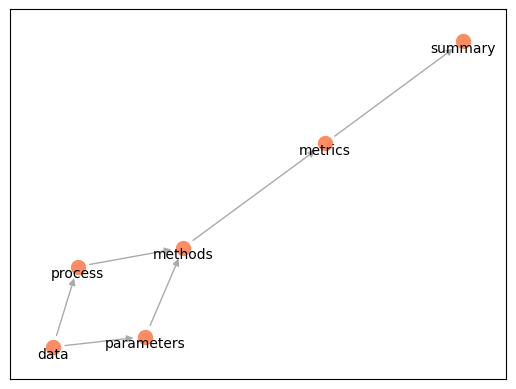

In [4]:
BENCHMARK_FILE='iris-benchmark.yaml'

from bench import build_dag_from_definition, plot_graph

g = build_dag_from_definition(BENCHMARK_FILE)
plot_graph(g)


Ok, now let's build a state machine to know when can we proceed to the next step...

In [5]:
from importlib import reload
import machine
reload(machine)
sm = machine.state_machine_from_graph(g)

print("current:", sm.state)
sm.data_to_parameters()
assert(sm.state == "parameters")
sm.parameters_to_methods()
assert(sm.state == "parameters")
print(sm.state)          # stuck because waiting for process
sm.done_state('process') # we're helping getting unstuck here, simulating external event
sm.parameters_to_methods()
assert(sm.state == "methods")
sm.methods_to_metrics()
assert(sm.state == "metrics")
sm.metrics_to_summary()
assert(sm.state == "summary")


current: data
exited: data
entered: parameters
parameters
exited: parameters
entered: methods
exited: methods
entered: metrics
exited: metrics
entered: summary


Ok, the state machine sort of works (however the transition needs to wait for a semaphore-like condition on states that have branched). It would be more natural if we can just specify branching properly, like this perhaps:

In [12]:
from importlib import reload
import machine
reload(machine)

sm = machine.state_machine_from_graph(g)
sm.state
sm.advance()
sm.state
ok = sm.advance()

if not ok:
    print(f"oh no! we're stuck in state: {sm.state}")
    pending = list(sm.waiting_on())

    needed = pending[0]
    print(f"waiting for: {needed}")
    sm.done_state(needed)
    print(f"state {needed} has been marked done, can we move on now?")
    
assert(sm.advance() == True)

# now we should be able to advance the state machine till the end
sm.advance()
sm.advance()
sm.advance()

exited: data
entered: process
oh no! we're stuck in state: process
waiting for: parameters
state parameters has been marked done, can we move on now?
exited: process
entered: methods
exited: methods
entered: metrics
exited: metrics
entered: summary
we're done!


True

This is cool! It basically means that we don't have to hardcode a single dependency graph anymore, but rather we can just express `after` dependencies in the yaml file, and construct an object with a state machine, and advance the state to whatever state we're waiting on. This is basically the internal state of the orchestrator.

Some of these states we want to launch and wait on, but some others we can just wait for indefinite periods of time (and possibly timeout if we'd no longer wait for them).
